In [87]:
# upgrade tables bo read_hdf wymaga zaraz
!pip install --upgrade tables
!pip install eli5
!pip install xgboost

Requirement already up-to-date: tables in /usr/local/lib/python3.6/dist-packages (3.6.1)


In [0]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score

import eli5
from eli5.sklearn import PermutationImportance


## wczytywanie danych

In [89]:
ls "/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car"

data/       day2_visualisation.ipynb  day4.ipynb  README.md
day1.ipynb  day3_first_model.ipynb    LICENSE


In [90]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car/data"

/content/drive/My Drive/Colab Notebooks/dw_matrix/matrix_two/dw_matrix_car/data


In [91]:
ls

car.h5


In [92]:
df = pd.read_hdf('car.h5')
df.shape

(106494, 155)

In [93]:
df.columns

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)

## features factorization

In [94]:
df.head(2)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,...,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,...,None,None,Firmy,90 KM,None,None,None,None,None,Benzyna+LPG,None,None,None,None,None,None,None,Logan,898 cm3,None,None,None,None,None,None,None,None,None,Inny kolor,None,None,Nowe,II (2012-),None,None,None,Tak,None,None,0
2,"[Osobowe, Peugeot, 3008, Peugeot 3008 I (2009-...","15:48, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji, Faktura VAT",28000.0,"Tomaszów Mazowiecki, tomaszowski, Łódzkie",None,Osoba prywatna,False,False,False,True,False,False,True,True,True,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,None,Tak,Osoby prywatnej,115 KM,None,Polska,None,None,None,Diesel,None,None,None,None,None,None,None,3008,1 560 cm3,None,None,None,None,None,None,None,None,None,Czarny,None,None,Używane,I (2009-2016),None,None,None,Tak,None,None,2


In [95]:
df['param_color'].factorize()

(array([-1, -1, -1, ..., -1, -1, -1]),
 Index(['Czarny', 'Srebrny', 'Złoty', 'Bordowy', 'Biały', 'Szary', 'Beżowy',
        'Zielony', 'Fioletowy', 'Niebieski', 'Inny kolor', 'Brązowy', 'Żółty'],
       dtype='object'))

In [96]:
pd.factorize(['asdf', 'asdff', 'qewr', None, 'asdf', None, 1,2,3,4,5, None])
# factorize uwzględnia elementy None, zamienia je na jeden wspólny o indeksie -1

(array([ 0,  1,  2, -1,  0, -1,  3,  4,  5,  6,  7, -1]),
 array(['asdf', 'asdff', 'qewr', 1, 2, 3, 4, 5], dtype=object))

In [0]:
SUFFIX_CAT = '__cat'
for feat in df.columns:
  if isinstance(df[feat][0], list): continue
  
  factorized_values = df[feat].factorize()[0]
  if SUFFIX_CAT in feat:
    df[feat] = factorized_values
  else:
    df[feat+SUFFIX_CAT] = factorized_values

In [98]:
cat_feats = [x for x in df.columns if SUFFIX_CAT in x]
# bez cen
cat_feats = [x for x in cat_feats if 'price' not in x]
len(cat_feats)

151

In [0]:
def run_model(model, feats=cat_feats):
  X = df[feats].values
  y = df['price_value'].values
  scores = cross_val_score(model, X, y, cv=3, scoring='neg_mean_absolute_error')
  return np.mean(scores), np.std(scores)

## DecisionTree

In [100]:
run_model(DecisionTreeRegressor(max_depth=5), cat_feats)

(-19695.13091100928, 148.72570644015937)

## Random Forest

In [101]:
model = RandomForestRegressor(max_depth=5, n_estimators=50, random_state=0)
run_model(model)

(-18718.657185256638, 64.5424578125788)

##XGBoost

In [102]:
xgb_params = {
    'max_depth': 5,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'random_state': 0,
    'seed': 0
}
run_model(xgb.XGBRegressor(**xgb_params))

[00:07:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:08:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-13108.379065811214, 74.32158265003798)

## ponowne sprawdzenie które feats wpływają na wynik

In [0]:
X = df[cat_feats].values
y = df['price_value'].values

In [104]:
m = xgb.XGBRegressor(**xgb_params)
m.fit(X,y)

imp = PermutationImportance(m, random_state = 0).fit(X,y)
eli5.show_weights(imp, feature_names=cat_feats)

[00:08:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Weight,Feature
0.1194 ± 0.0031,param_napęd__cat
0.1132 ± 0.0032,param_rok-produkcji__cat
0.1090 ± 0.0025,param_stan__cat
0.0619 ± 0.0025,param_skrzynia-biegów__cat
0.0568 ± 0.0016,param_faktura-vat__cat
0.0489 ± 0.0014,param_moc__cat
0.0273 ± 0.0007,param_marka-pojazdu__cat
0.0242 ± 0.0013,feature_kamera-cofania__cat
0.0212 ± 0.0008,param_typ__cat
0.0174 ± 0.0008,param_pojemność-skokowa__cat


In [105]:
# biorę tylko te ~20 o największym wpływie:
feats = ['param_napęd__cat','param_rok-produkcji__cat','param_stan__cat','param_skrzynia-biegów__cat','param_faktura-vat__cat','param_moc__cat','param_marka-pojazdu__cat','feature_kamera-cofania__cat','param_typ__cat','param_pojemność-skokowa__cat','seller_name__cat','feature_wspomaganie-kierownicy__cat','param_model-pojazdu__cat','param_wersja__cat','param_kod-silnika__cat','feature_system-start-stop__cat','feature_asystent-pasa-ruchu__cat','feature_czujniki-parkowania-przednie__cat','feature_łopatki-zmiany-biegów__cat','feature_regulowane-zawieszenie__cat']
run_model(xgb.XGBRegressor(**xgb_params), feats)
# daje wynik trochę gorszy, ale z mniejszym odchyleniem standardowym

[00:13:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:13:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-13375.230420852275, 65.40441107118909)

## zmienne numeryczne lepiej nie faktoryzować, bo tracimy informacje o wzajemnych odległościach

In [0]:
df['param_rok-produkcji'] = df['param_rok-produkcji'].map(lambda x: -1 if str(x) == 'None' else int(x))

In [107]:
# rok produkcji liczbowo
feats = ['param_napęd__cat','param_rok-produkcji','param_stan__cat','param_skrzynia-biegów__cat','param_faktura-vat__cat','param_moc__cat','param_marka-pojazdu__cat','feature_kamera-cofania__cat','param_typ__cat','param_pojemność-skokowa__cat','seller_name__cat','feature_wspomaganie-kierownicy__cat','param_model-pojazdu__cat','param_wersja__cat','param_kod-silnika__cat','feature_system-start-stop__cat','feature_asystent-pasa-ruchu__cat','feature_czujniki-parkowania-przednie__cat','feature_łopatki-zmiany-biegów__cat','feature_regulowane-zawieszenie__cat']
run_model(xgb.XGBRegressor(**xgb_params), feats)

[00:14:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-11308.885890938496, 27.868488259630677)

In [0]:
df['param_moc'] = df['param_moc'].map(lambda x: -1 if str(x) == 'None' else int(str(x).split(' ')[0]))

In [109]:
feats = ['param_napęd__cat','param_rok-produkcji','param_stan__cat','param_skrzynia-biegów__cat','param_faktura-vat__cat','param_moc','param_marka-pojazdu__cat','feature_kamera-cofania__cat','param_typ__cat','param_pojemność-skokowa__cat','seller_name__cat','feature_wspomaganie-kierownicy__cat','param_model-pojazdu__cat','param_wersja__cat','param_kod-silnika__cat','feature_system-start-stop__cat','feature_asystent-pasa-ruchu__cat','feature_czujniki-parkowania-przednie__cat','feature_łopatki-zmiany-biegów__cat','feature_regulowane-zawieszenie__cat']
run_model(xgb.XGBRegressor(**xgb_params),feats)

[00:14:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-9716.450230340148, 62.2164408321879)

In [110]:
df['param_pojemność-skokowa'] = df['param_pojemność-skokowa'].map(lambda x: -1 if str(x) == 'None' else int(str(x).split('cm')[0].replace(' ','')))
feats = ['param_napęd__cat','param_rok-produkcji','param_stan__cat','param_skrzynia-biegów__cat','param_faktura-vat__cat','param_moc','param_marka-pojazdu__cat','feature_kamera-cofania__cat','param_typ__cat','param_pojemność-skokowa','seller_name__cat','feature_wspomaganie-kierownicy__cat','param_model-pojazdu__cat','param_wersja__cat','param_kod-silnika__cat','feature_system-start-stop__cat','feature_asystent-pasa-ruchu__cat','feature_czujniki-parkowania-przednie__cat','feature_łopatki-zmiany-biegów__cat','feature_regulowane-zawieszenie__cat']
run_model(xgb.XGBRegressor(**xgb_params),feats)

[00:14:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-9569.227198767323, 72.83561801421891)

# dodaję moje zmiany

## price_currency remove EUR

In [111]:
df['price_currency'].value_counts()

PLN    106290
EUR       204
Name: price_currency, dtype: int64

In [112]:
df['price_currency'].value_counts(normalize=True)*100

PLN    99.80844
EUR     0.19156
Name: price_currency, dtype: float64

In [113]:
df = df[ df['price_currency'] != 'EUR' ]
df.shape

(106290, 309)

## param_przebieg

In [0]:
df['param_przebieg_int'] = df['param_przebieg'].map(lambda x: int(str(x).replace("km","").replace(" ", "")) if x else 0).astype(int)

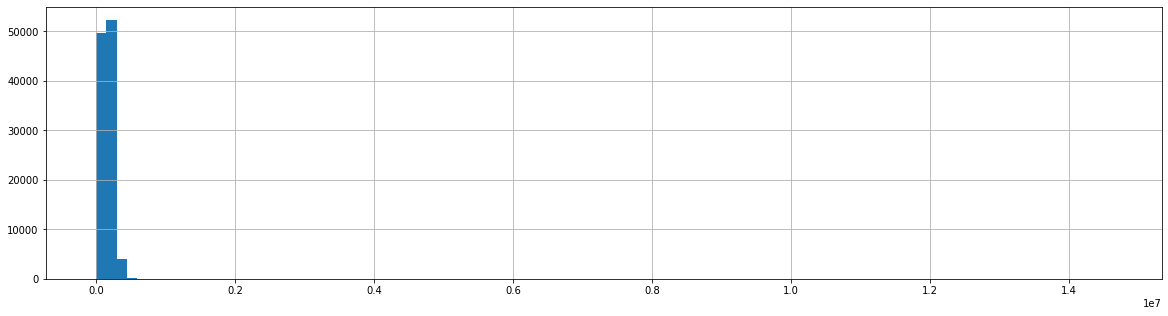

In [115]:
# max coś strasznie duży (dziesiąt milionów?)
df.param_przebieg_int.hist(bins=100, figsize=(20,5));

In [0]:
# odcinam odstające wartości powyżej 1mln
df['param_przebieg_int'] = df['param_przebieg_int'].map(lambda x: x if x < 1000000 else -1)  #do modelu nie może być None, więc daję -1 znaczące brak

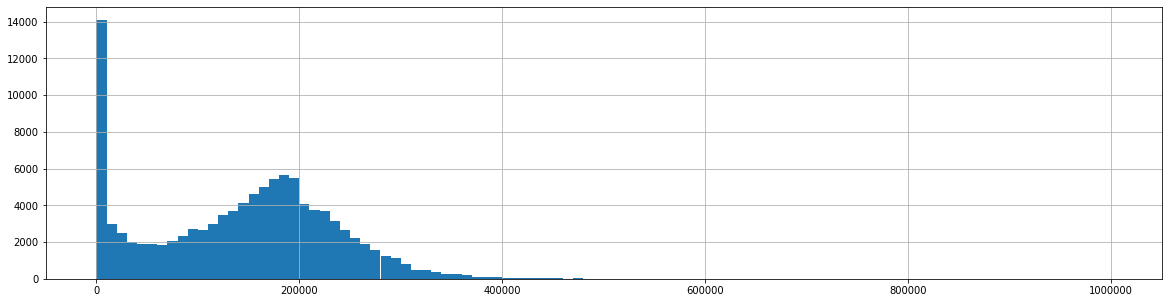

In [117]:
df.param_przebieg_int.hist(bins=100, figsize=(20,5));

## dodaję przebieg przeliczony na przedziały

In [118]:
df[df['param_przebieg_int']==df['param_przebieg_int'].max()][['breadcrumb','price_value','param_marka-pojazdu', 'param_model','param_rok-produkcji','param_przebieg']]

,breadcrumb,price_value,param_marka-pojazdu,param_model,param_rok-produkcji,param_przebieg
32075,"[Osobowe, Volvo, 850]",13500.0,Volvo,None,1995,999 999 km
38256,"[Osobowe, Audi, A4, Audi A4 B5 (1995-2001)]",8950.0,Audi,None,2000,999 999 km
61250,"[Osobowe, BMW, Seria 7, 745, BMW Seria 7 E65/6...",6900.0,BMW,None,2004,999 999 km
66091,"[Osobowe, Volkswagen, Transporter, Volkswagen ...",63000.0,Volkswagen,None,1975,999 999 km
111893,"[Osobowe, Chrysler, Inny]",299900.0,Chrysler,None,1932,999 999 km
127304,"[Osobowe, Volkswagen, Transporter, Volkswagen ...",69000.0,Volkswagen,None,1977,999 999 km
155919,"[Osobowe, Volkswagen, Garbus]",54000.0,Volkswagen,None,1952,999 999 km


jeszcze skubełkowanie (choć po usunięciu odstających, już chyba nie potrzebne, bo ten histogram jest całkime ok)
w zasadzie do wizualizacji się przyda
można się jeszcze zastanowić nad większym usunięciem ogona, ciekawe co da

In [0]:
df['param_przebieg_bins'] = pd.cut(df['param_przebieg_int'],20).map(lambda x: x.right)
# qcut rozcina na równe kawałki ilościowo
# qcut po prostu dzieli oś X

In [120]:
df['param_przebieg_bins'].value_counts()

199999.0    26221
49999.0     23431
249999.0    17290
149999.0    16876
99999.0     10827
299999.0     8086
349999.0     2399
399999.0      776
449999.0      216
499999.0       88
549999.0       32
599999.0       19
999999.0        8
649999.0        6
799999.0        6
699999.0        3
949999.0        2
749999.0        2
899999.0        2
849999.0        0
Name: param_przebieg_bins, dtype: int64

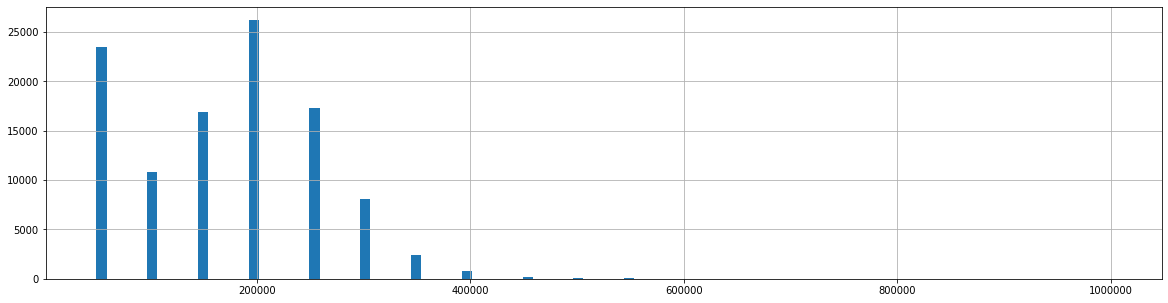

In [121]:
df.param_przebieg_bins.hist(bins=100, figsize=(20,5));

In [0]:
def group_and_barplot(feat_groupby, feat_agg='price_value', agg_funcs=[np.mean, np.median, np.size], feat_sort='mean', ascending=False, top=50, subplots=True, ):
  return(
    df
    .groupby(feat_groupby)[feat_agg]
    .agg(agg_funcs)
    .sort_values(by=feat_sort, ascending=ascending)
    .head(top)
  ).plot(kind='bar', figsize=(20,5), subplots=subplots)

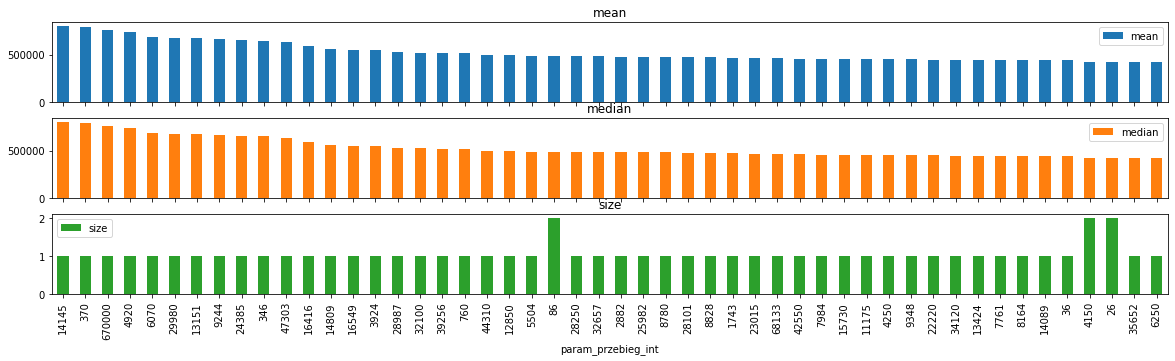

In [123]:
group_and_barplot('param_przebieg_int');

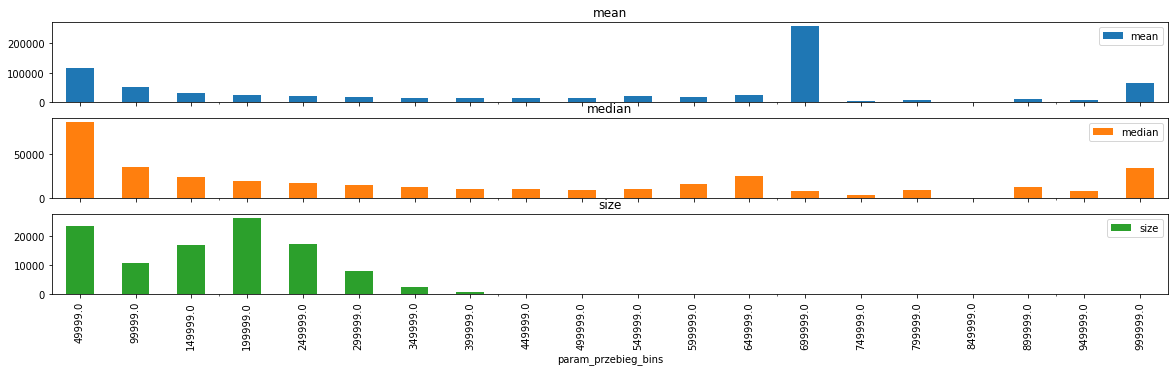

In [124]:
group_and_barplot('param_przebieg_bins', feat_sort='param_przebieg_bins', ascending=True);

dorzucam nowe kolumny do features

In [125]:
moje_feats = feats + ['param_przebieg_bins', 'param_przebieg_int']
len(moje_feats)

22

## sprawdzam wynik modelu

In [126]:
run_model(xgb.XGBRegressor(**xgb_params),moje_feats)

[00:14:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-9307.165843652794, 71.91285673102912)

## ponowne sprawdzenie które feats wpływają na wynik

In [0]:
all_feats =  list(set(cat_feats) | set(moje_feats)) 
X = df[all_feats].values
y = df['price_value'].values

In [128]:
m = xgb.XGBRegressor(**xgb_params)
m.fit(X,y)

imp = PermutationImportance(m, random_state = 0).fit(X,y)
eli5.show_weights(imp, feature_names=all_feats)

[00:15:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Weight,Feature
0.4025 ± 0.0048,param_rok-produkcji
0.3259 ± 0.0016,param_moc
0.0772 ± 0.0012,param_przebieg_int
0.0292 ± 0.0005,param_pojemność-skokowa
0.0191 ± 0.0003,param_marka-pojazdu__cat
0.0150 ± 0.0003,param_napęd__cat
0.0145 ± 0.0007,param_rodzaj-paliwa__cat
0.0123 ± 0.0004,param_kod-silnika__cat
0.0116 ± 0.0003,param_wersja__cat
0.0080 ± 0.0003,param_typ__cat


In [129]:
# biorę tylko te ~20 o największym wpływie po dodani moich kolumn
feats = ['param_rok-produkcji','param_moc','param_przebieg_int','param_pojemność-skokowa','param_marka-pojazdu__cat','param_napęd__cat','param_rodzaj-paliwa__cat','param_kod-silnika__cat','param_wersja__cat','param_typ__cat','param_uszkodzony__cat','param_skrzynia-biegów__cat','seller_name__cat','param_bezwypadkowy__cat','param_model-pojazdu__cat','feature_czujniki-parkowania-przednie__cat','param_faktura-vat__cat','param_pojemność-skokowa__cat','feature_asystent-pasa-ruchu__cat','feature_kamera-cofania__cat']
run_model(xgb.XGBRegressor(**xgb_params), feats)

[00:20:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:20:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


(-8888.965998494477, 61.35790253138393)

i ten wynik jest lepszy!
(-8888.965998494477, 61.35790253138393)